In [246]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from steinlib.instance import SteinlibInstance 
from steinlib.parser import SteinlibParser

In [233]:
class MySteinlibInstance(SteinlibInstance): 
    def __init__(self):
        self.my_graph = nx.Graph() 
        self.terms = []
        
    def terminals__t(self, line, converted_token): 
        self.terms.append(converted_token[0])
        
    def graph__e(self, line, converted_token):
        e_start = converted_token [0]
        e_end   = converted_token [1]
        weight  = converted_token [2]
        self.my_graph.add_edge(e_start , e_end , weight=weight)

In [238]:
def load_stein_file (instance_class, id):
    stein_file = f"data/{instance_class}/{id}.stp" 
    my_class = MySteinlibInstance() 
    with open(stein_file) as my_file:
        my_parser = SteinlibParser(my_file , my_class) 
        my_parser.parse()
        terms = my_class.terms
        graph = my_class.my_graph
    return graph , terms


In [8]:
# verify if a solution is correct and evaluate it
def eval_sol(graph, terminals, sol) -> float:
    graph_sol = nx.Graph()
    for (i, j) in sol:
        if (i, j) in graph_sol.edges:
            graph_sol[i][j]['weight'] = 1 + graph_sol[i][j].get('weight', 1)
        else:
            graph_sol.add_edge(i, j, weight=graph[i][j].get('weight', 1))

    if not nx.is_tree(graph_sol):
        print ("Error: the proposed solution is not a tree")
        return -1

    for i in terminals:
        if not i in graph_sol:
            print ("Error: a terminal is missing from the solution")
            return -1

    cost = graph_sol.size(weight='weight')
    return cost

In [12]:
def two_approximation(G, terms):
    # Step 1: Create the complete graph K using shortest paths between all terminal pairs
    K = nx.Graph()
    shortest_paths = {}
    for u in terms:
        for v in terms:
            if u != v:
                length, path = nx.single_source_dijkstra(G, u, target=v)
                K.add_edge(u, v, weight=length)
                shortest_paths[(u, v)] = path

    # Step 2: Compute the Minimum Spanning Tree A from graph K
    A = nx.minimum_spanning_tree(K, algorithm="kruskal")

    # Step 3: Unfold shortest path edges in G for each edge (u, v) in A
    steiner_edges = []
    for u, v in A.edges():
        path = shortest_paths[(u, v)]
        
        for i in range(len(path) - 1):
            steiner_edges.append((path[i], path[i + 1]))

    return steiner_edges

In [120]:
def create_graphs(n,s,model,**kwargs):
    Graphs = []
    while len(Graphs) < n:
        if model == nx.generators.random_graphs.random_regular_graph:
            G = model(kwargs['d'], s)
        else:
            G = model(s, **kwargs)
        while not nx.is_connected(G):
            if model == nx.generators.random_graphs.random_regular_graph:
                G = model(kwargs['d'], s)
            else:
                G = model(s, **kwargs)
        Graphs.append(G)
    return Graphs

In [121]:
graph_series = create_graphs(5, 10, nx.generators.binomial_graph, p=0.5)

In [122]:
def average_solution(Graphs,f,terms):
    total_weight = 0
    for G in Graphs:
        weight = eval_sol(G,terms,f(G,terms))
        total_weight += weight
    average_weight = total_weight / len(Graphs)
    return average_weight

In [126]:
 def three_terminal_steiner_tree(G, t0, t1, t2):
    # Step 1: Compute shortest paths between all pairs of terminals
    dist_01, path_01 = nx.single_source_dijkstra(G, t0, target=t1, weight='weight')
    dist_02, path_02 = nx.single_source_dijkstra(G, t0, target=t2, weight='weight')
    dist_12, path_12 = nx.single_source_dijkstra(G, t1, target=t2, weight='weight')
    
    # Step 2: Try all possible ways to connect the terminals via paths through intermediate nodes
    path_t0_t1 = path_01
    path_t2_to_path_01 = nx.shortest_path(G, source=t2, target=path_t0_t1[-1], weight='weight')
    tree_1 = path_t0_t1 + path_t2_to_path_01[1:]
    
    path_t0_t2 = path_02
    path_t1_to_path_02 = nx.shortest_path(G, source=t1, target=path_t0_t2[-1], weight='weight')
    tree_2 = path_t0_t2 + path_t1_to_path_02[1:]
    
    path_t1_t2 = path_12
    path_t0_to_path_12 = nx.shortest_path(G, source=t0, target=path_t1_t2[-1], weight='weight')
    tree_3 = path_t1_t2 + path_t0_to_path_12[1:]
    
    # Step 3: Compare all three options and return the one with the least cost
    def calculate_total_cost(tree):
        total_cost = 0
        for u, v in zip(tree[:-1], tree[1:]):
            # Check if edge exists before trying to access it
            if G.has_edge(u, v):
                total_cost += G[u][v].get('weight', 1)  
        return total_cost
    
    try:
        total_cost_1 = calculate_total_cost(tree_1)
        total_cost_2 = calculate_total_cost(tree_2)
        total_cost_3 = calculate_total_cost(tree_3)
    except KeyError as e:
        print(f"Error: {e}")
        return None  
    
    return min(total_cost_1, total_cost_2, total_cost_3)

In [212]:
 def lower_bound_k_terminal_steiner(G, terms):
    if len(terms) == 3:
        return three_terminal_steiner_tree(G, terms[0], terms[1], terms[2])
    
    # Use combinations of triples to estimate the lower bound
    max_bound = -1
    for comb in combinations(terms, 3):
        bound = three_terminal_steiner_tree(G, comb[0], comb[1], comb[2])
        max_bound = max(max_bound, bound)
    
    return max_bound 

In [190]:
def average_lower_bound_k_terminal_steiner(graph_series,terms):
    total_bound = 0
    for G in graph_series:
        lb = lower_bound_k_terminal_steiner(G, terms)
        total_bound += lb
    average_bound = total_bound / len(graph_series)
    return average_bound

In [191]:
def lower_bound_shortest_path(G,terms):
    shortest_path_bound = 0
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            path_length = nx.shortest_path_length(G, source=terms[i], target=terms[j], weight='weight')
            shortest_path_bound = max(shortest_path_bound, path_length)
    return shortest_path_bound

In [192]:
def average_lower_bound_shortest_path(graph_series,terms):
    total_bound = 0
    for G in graph_series:
        lb = lower_bound_shortest_path(G, terms)
        total_bound += lb
    average_bound = total_bound / len(graph_series)
    return average_bound

In [193]:
def plot_average_solution_vs_parameter(parameter_values,n,s,model,f,terms,**kwargs):
    average_weights = []
    average_short_path_bounds = []
    average_k_terms_bounds = []
    for value in parameter_values:
        kwargs['p'] = value
        graph_series = create_graphs(n, s, model, **kwargs)
        average_weight = average_solution(graph_series, f, terms)
        average_short_path_bound = average_lower_bound_shortest_path(graph_series, terms)
        average_k_term_bound = average_lower_bound_k_terminal_steiner(graph_series, terms)
        average_weights.append(average_weight)
        average_short_path_bounds.append(average_short_path_bound)
        average_k_terms_bounds.append(average_k_term_bound)

    plt.plot(parameter_values, average_weights, marker='o', label='Apprix')
    plt.plot(parameter_values, average_short_path_bounds, marker='x', linestyle='--', label='Bound shortest path')
    plt.plot(parameter_values, average_k_terms_bounds, marker='x', linestyle='--', label='Bound k terminals')
    plt.xlabel('Parameter Value (p)')
    plt.ylabel('Average Weight')
    plt.title(f'random binomial graph - Size of graphs : {s} nodes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [194]:
def generate_random_terminals(T, N):
    if N < 2:
        raise ValueError("N must be at least 2.")
    if T > N:
        raise ValueError("T must be less than or equal to N.")
    
    elements = random.sample(range(N), N)
    
    result = elements[:T]
    
    return result

In [225]:
def plot_average_solution_vs_terminals(title, n,s,model,f,**kwargs):
    average_weights = []
    average_bounds = []
    percentages = [0] + [p / 100 for p in range(10, 101, 10)]
    graph_series = create_graphs(n, s, model, **kwargs)
    for percentage in percentages:
        num_terminals = max(2, int(s * percentage))
        terminals = generate_random_terminals(num_terminals, s)
        average_weight = average_solution(graph_series, f, terminals)
        average_bound = average_lower_bound_shortest_path(graph_series, terminals)
        average_weights.append(average_weight)
        average_bounds.append(average_bound)

    plt.plot([p * 100 for p in percentages], average_weights, marker='o', label='Apprix')
    plt.plot([p * 100 for p in percentages], average_bounds,  marker='x', linestyle='--', label='Bound shortest path')
    plt.xlabel('Percentage of terminals')
    plt.ylabel('Average Weight')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [226]:
graph_series = create_graphs(5, 10, nx.generators.binomial_graph, p=0.5)
terminals = [0, 1, 2, 3, 4]
average_weight = average_solution(graph_series, two_approximation, terminals)
average_s_p_bound = average_lower_bound_shortest_path(graph_series, terminals)
average_k_t_bound = average_lower_bound_k_terminal_steiner(graph_series, terminals)
print(f"Average Shortest Path Lower Bound: {average_s_p_bound}")
print(f"Average K terminals Lower Bound: {average_k_t_bound}")
print(f"Average Steiner Tree weight: {average_weight}")

Average Shortest Path Lower Bound: 2.6
Average K terminals Lower Bound: 3.6
Average Steiner Tree weight: 4.4


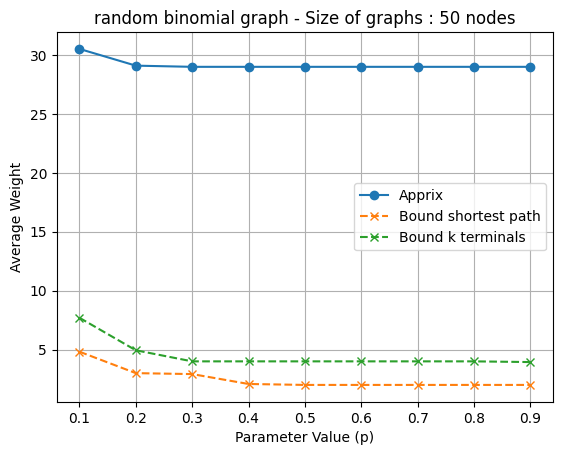

In [224]:
parameter_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_graphs = 50
nb_nodes = 50
terminals = generate_random_terminals(30, 50)
plot_average_solution_vs_parameter(parameter_values, nb_graphs, nb_nodes, nx.generators.binomial_graph, two_approximation, terminals)

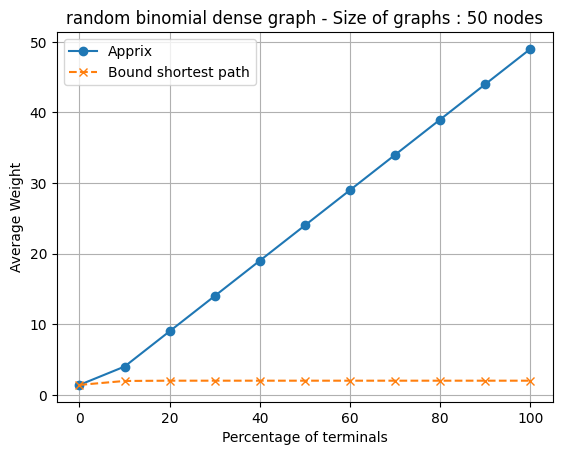

In [228]:
nb_graphs = 50
nb_nodes = 50
title = f'random binomial dense graph - Size of graphs : {nb_nodes} nodes'
plot_average_solution_vs_terminals(title, nb_graphs,nb_nodes,nx.generators.binomial_graph,two_approximation, p = 0.7)

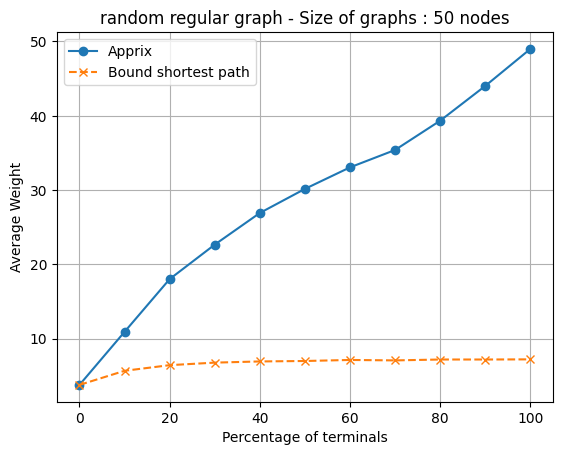

In [229]:
title = f'random regular graph - Size of graphs : {nb_nodes} nodes'
plot_average_solution_vs_terminals(title, nb_graphs, nb_nodes, nx.generators.random_graphs.random_regular_graph, two_approximation, d=3)

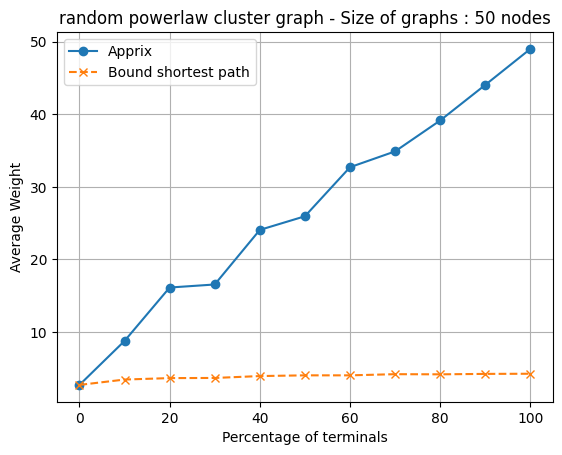

In [230]:
title = f'random powerlaw cluster graph - Size of graphs : {nb_nodes} nodes'
plot_average_solution_vs_terminals(title, nb_graphs, nb_nodes, nx.generators.random_graphs.powerlaw_cluster_graph, two_approximation, m=3, p=0.7)


In [242]:
OptB = [82, 83, 138, 59, 61, 122, 111, 104, 220, 86, 88, 174, 165, 235, 318, 127, 131, 218]
OptC = [85, 144, 754, 1079, 1579, 55, 102, 509, 707, 1093, 32, 46, 258, 323, 556, 11, 18, 113, 146, 267]

In [252]:
def plot_algorithm_comparison(class_name, instance_names, approximation, optimal, best_bound):
    bar_width = 0.25
    x = np.arange(len(instance_names))

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width, approximation, width=bar_width, label="Approximation", color="blue")
    plt.bar(x, optimal, width=bar_width, label="Optimal", color="orange")
    plt.bar(x + bar_width, best_bound, width=bar_width, label="Best Bound",color="green")

    plt.xlabel("Instance")
    plt.ylabel("Weight")
    plt.title(f"Comparison of algorithms on Steinlib instances of class {class_name}")
    plt.xticks(x, instance_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

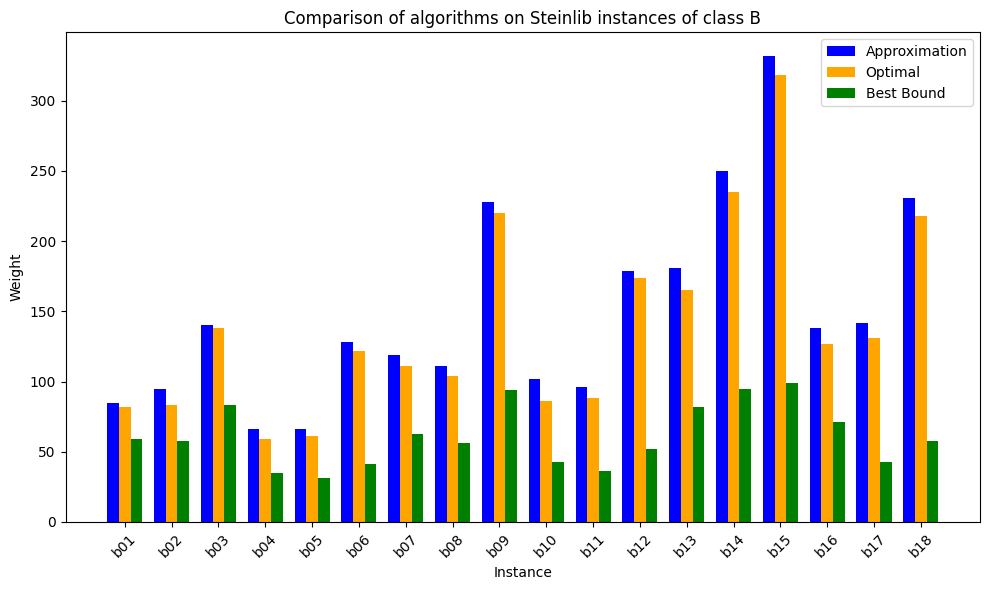

In [253]:
instance_names_b = ["b01", "b02", "b03", "b04", "b05", "b06", "b07", "b08", "b09", "b10", "b11", "b12", "b13", "b14", "b15", "b16", "b17", "b18"]
approximation = []
best_bound = []
for id in instance_names_b:
    G, terms = load_stein_file ("B", id)
    app_weight = eval_sol(G,terms,two_approximation(G,terms))
    lower_bound_short_path = lower_bound_shortest_path(G,terms)
    lower_bound_k_terms = lower_bound_k_terminal_steiner(G, terms)
    approximation.append(app_weight)
    best_bound.append(max(lower_bound_short_path, lower_bound_k_terms))
plot_algorithm_comparison("B", instance_names, approximation, OptB, best_bound)


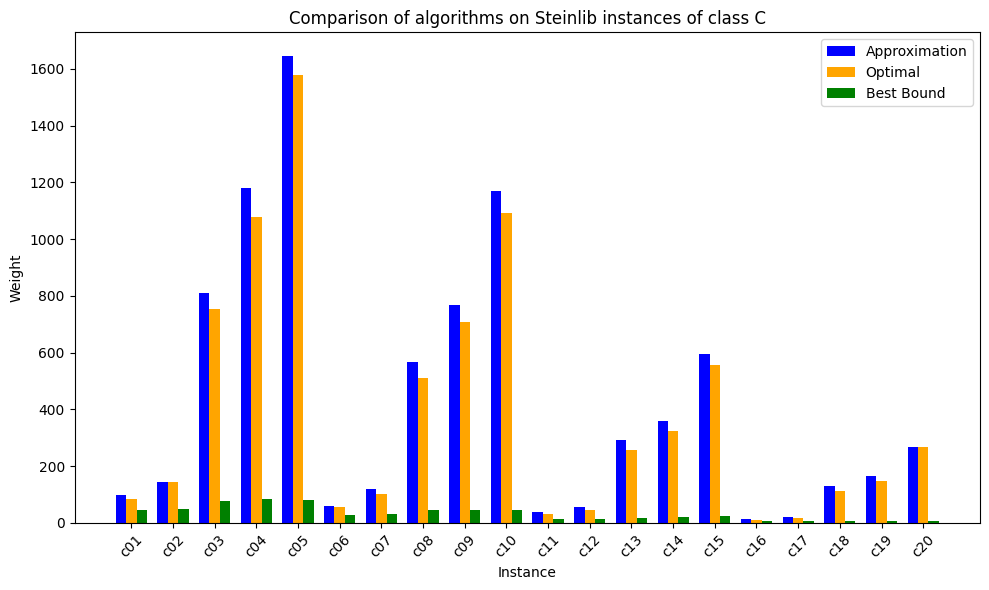

In [259]:
instance_names_c = ["c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10", 
                    "c11", "c12", "c13", "c14", "c15", "c16", "c17", "c18", "c19", "c20"]
approximation = []
best_bound = []
for id in instance_names_c:
    G, terms = load_stein_file ("C", id)
    app_weight = eval_sol(G,terms,two_approximation(G,terms))
    lower_bound_short_path = lower_bound_shortest_path(G,terms)
    #lower_bound_k_terms = lower_bound_k_terminal_steiner(G, terms)
    approximation.append(app_weight)
    #best_bound.append(max(lower_bound_short_path, lower_bound_k_terms))
    best_bound.append(lower_bound_short_path)
plot_algorithm_comparison("C", instance_names_c, approximation, OptC, best_bound)
